# **AMERICAN SIGN LANGUAGE RECOGNITION PROJECT**

# Setting up the environment and kaggle API

**Importing tensorflow and checking tensorflow:**

In [75]:
import tensorflow as tf

print(tf.__version__)

1.15.0-rc3


**Installing kaggle so as to download the dataset using kaggle API:**

In [0]:
!pip install -q kaggle

**Setting up the kaggle.json authentication file enabling me to download the dataset:**

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Downloading the grassknoted/asl-alphabet available [here](https://www.kaggle.com/grassknoted/asl-alphabet)

**Downloading the dataset using the API:**

In [78]:
!kaggle datasets download -d grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


**Extracting the contents:**

In [79]:
!unzip asl-alphabet.zip

Archive:  asl-alphabet.zip
replace asl_alphabet_test/asl_alphabet_test/A_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Looking at the dataset

**Specifying train and test directories:**

In [0]:
# Specifying the training and test directories

TRAINING_DIR = './asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = './asl_alphabet_test/asl_alphabet_test/'

**Looking at some random images from the dataset:**

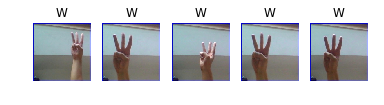

In [165]:
# Printing 5 random images from any training category or from a specified category
%matplotlib inline

import cv2
import os
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

number_of_rows = 1
number_of_columns = 5

categories = os.listdir(TRAINING_DIR)

random.seed(13)

category = categories[random.randint(1, 30)]
# category = 'A'

for i in range(number_of_columns):
  subplot = plt.subplot(number_of_rows, number_of_columns, i + 1)
  subplot.axis('Off')
  subplot.set_title(category)
  image_path = os.path.join(
      TRAINING_DIR,
      str(category),
      str(category) + str(random.randint(1, 1000)) + '.jpg'
  )
  image = mpimg.imread(image_path)
  plt.imshow(image)
  
plt.show()

# Preparing the training set

**Augmenting the data with brightness and zoom ranges:**

In [166]:
# Preparing ImageDataGenerator object for training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


# Preparing the model for training

**Downloading custom weight file if required:**

In [145]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-10-09 00:38:03--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M   123MB/s    in 0.7s    

2019-10-09 00:38:04 (123 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



**Preparing Inception V3 Network for transfer learning:**

In [175]:
# Loading inception v3 network for transfer learning
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

# Not required --> inception_v3_model.load_weights(WEIGHTS_FILE)

# Enabling the top 2 inception blocks to train
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True
    
# Checking model summary to pick a layer (if required)
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1222 (Conv2D)            (None, 99, 99, 32)   864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1222 (Batch (None, 99, 99, 32)   96          conv2d_1222[0][0]                
__________________________________________________________________________________________________
activation_1222 (Activation)    (None, 99, 99, 32)   0           batch_normalization_1222[0][0]   
_______________________________________________________________________________________

**Choosing the inception output layer:**

In [176]:
# Choosing the output layer to be merged with our FC layers (if required)
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

# Not required --> inception_output = inception_output_layer.output
inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


**Adding our own set of fully connected layers at the end of Inception v3 network:**

In [0]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)
# Not required --> x = layers.Dropout(0.2)(x)                  
x = layers.Dense(29, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

**Looking at the final model:**

In [178]:
# Watch the new model summary
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1222 (Conv2D)            (None, 99, 99, 32)   864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1222 (Batch (None, 99, 99, 32)   96          conv2d_1222[0][0]                
__________________________________________________________________________________________________
activation_1222 (Activation)    (None, 99, 99, 32)   0           batch_normalization_1222[0][0]   
___________________________________________________________________________________________

**Setting up a callback funtion in order to stop training at a particular threshold:**

In [0]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

# Training the model generated using Inception v3 and our own set of Fully Connected layers

**Fitting the model to the training dataset:**

In [180]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
100/100 [==============================] - 191s 2s/step - loss: 3.3793 - acc: 0.0614 - val_loss: 3.4233 - val_acc: 0.0569
Epoch 2/50
100/100 [==============================] - 152s 2s/step - loss: 3.1502 - acc: 0.1695 - val_loss: 3.1327 - val_acc: 0.1412
Epoch 3/50
100/100 [==============================] - 153s 2s/step - loss: 2.8890 - acc: 0.3264 - val_loss: 2.9388 - val_acc: 0.2616
Epoch 4/50
100/100 [==============================] - 154s 2s/step - loss: 2.5856 - acc: 0.4628 - val_loss: 2.6841 - val_acc: 0.3856
Epoch 5/50
100/100 [==============================] - 154s 2s/step - loss: 2.2664 - acc: 0.5772 - val_loss: 2.4019 - val_acc: 0.4950
Epoch 6/50
100/100 [==============================] - 155s 2s/step - loss: 1.9700 - acc: 0.6530 - val_loss: 2.1017 - val_acc: 0.5903
Epoch 7/50
100/100 [==============================] - 155s 2s/step - loss: 1.6815 - acc: 0.7348 - val_loss: 1.7899 - val_acc: 0.6687
Epoch 8/50
100/100 [==============================] - 154s 2s/step - 

# Plotting the results

**Training Accuracy vs Validation Accuracy:**

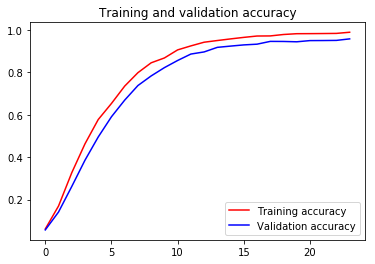

<Figure size 432x288 with 0 Axes>

In [181]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

**Training Loss vs Validation Loss**

<Figure size 432x288 with 0 Axes>

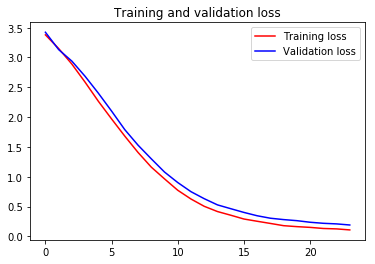

<Figure size 432x288 with 0 Axes>

In [201]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

# Saving the model

**As we were satisfied with our results we save our model:**

In [0]:
# Saving the model
MODEL_NAME = 'models/asl_alphabet_{}.h5'.format(9575)
model.save(MODEL_NAME)

# Testing our model

**Plotting images along with their respective actual and predicted classes:**

Actual class: V
Predicted class: V


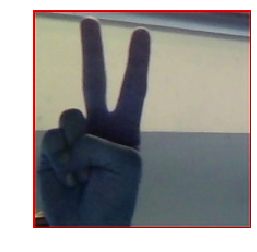

Actual class: O
Predicted class: O


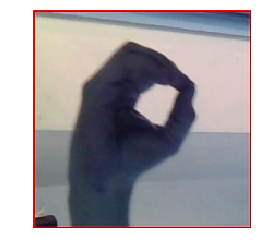

Actual class: B
Predicted class: B


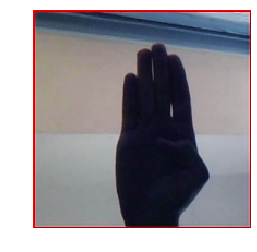

Actual class: D
Predicted class: D


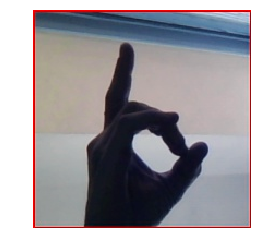

Actual class: I
Predicted class: I


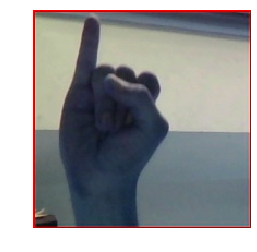

Actual class: U
Predicted class: U


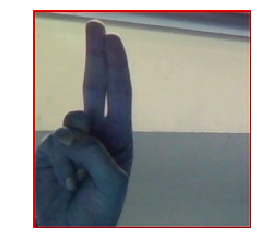

Actual class: T
Predicted class: T


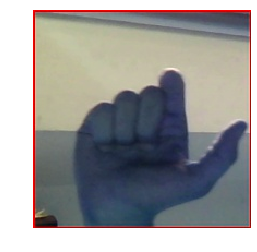

Actual class: P
Predicted class: P


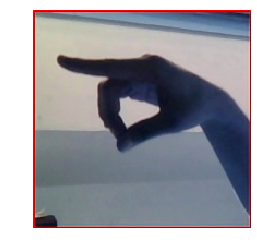

Actual class: S
Predicted class: S


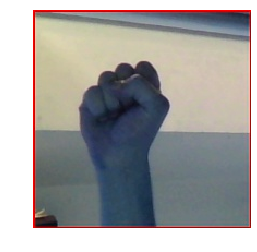

Actual class: J
Predicted class: J


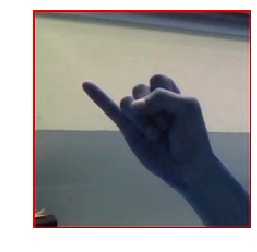

Actual class: nothing
Predicted class: nothing


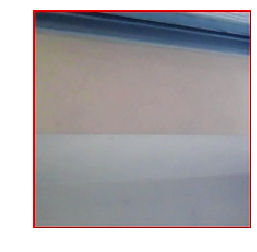

Actual class: E
Predicted class: E


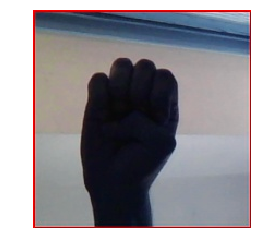

Actual class: N
Predicted class: N


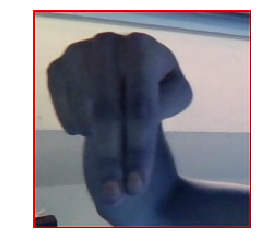

Actual class: K
Predicted class: K


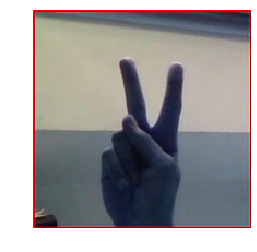

Actual class: Z
Predicted class: Z


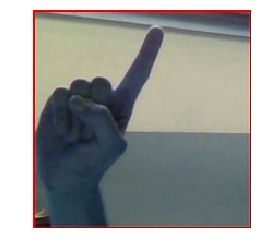

Actual class: Y
Predicted class: J


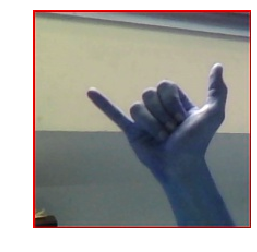

Actual class: H
Predicted class: H


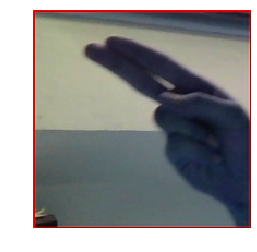

Actual class: L
Predicted class: L


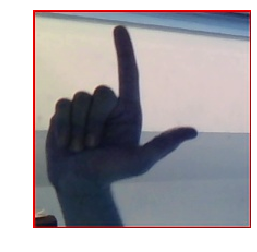

Actual class: X
Predicted class: X


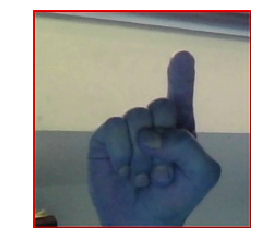

Actual class: A
Predicted class: A


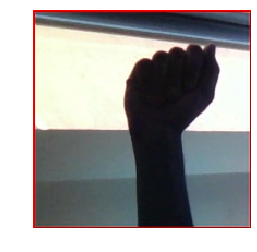

Actual class: G
Predicted class: G


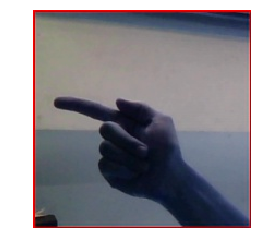

Actual class: W
Predicted class: W


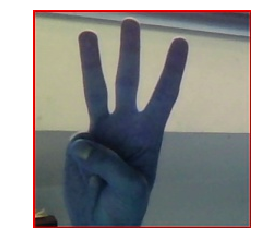

Actual class: F
Predicted class: F


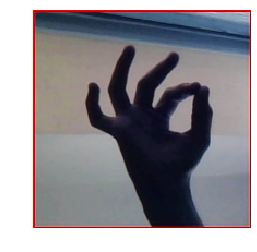

Actual class: M
Predicted class: M


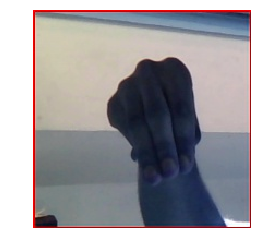

Actual class: C
Predicted class: C


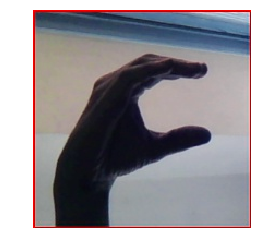

Actual class: R
Predicted class: R


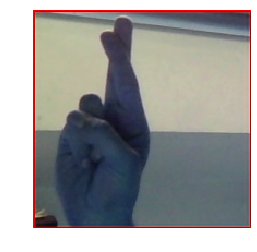

Actual class: Q
Predicted class: Q


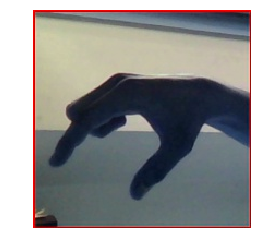

Actual class: space
Predicted class: space


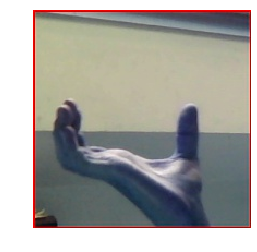

In [197]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

classes = os.listdir(TRAINING_DIR)
classes.sort()

for i, test_image in enumerate(os.listdir(TEST_DIR)):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    plt.figure()
    plt.axis('Off')
    plt.imshow(img)
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    plt.show()

**Calculating test accuracy:**

In [200]:
test_images = os.listdir(TEST_DIR)
total_test_cases = len(test_images)
total_correctly_classified = 0
total_misclassified = 0
for i, test_image in enumerate(test_images):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} - Predicted class: {}'.format(
        actual, predicted), end=' ')
    if actual == predicted:
      print('PASS!')
      total_correctly_classified += 1
    else:
      print('FAIL!')
      total_misclassified += 1
print("=" * 20)
test_accuracy = (total_correctly_classified / total_test_cases) * 100
test_error_rate = (total_misclassified / total_test_cases) * 100

print('Test accuracy (%):', test_accuracy)
print('Test error rate (%):', test_error_rate)
print('Number of misclassified classes:', total_misclassified)
print('Number of correctly classified classes', total_correctly_classified)

Actual class: V - Predicted class: V PASS!
Actual class: O - Predicted class: O PASS!
Actual class: B - Predicted class: B PASS!
Actual class: D - Predicted class: D PASS!
Actual class: I - Predicted class: I PASS!
Actual class: U - Predicted class: U PASS!
Actual class: T - Predicted class: T PASS!
Actual class: P - Predicted class: P PASS!
Actual class: S - Predicted class: S PASS!
Actual class: J - Predicted class: J PASS!
Actual class: nothing - Predicted class: nothing PASS!
Actual class: E - Predicted class: E PASS!
Actual class: N - Predicted class: N PASS!
Actual class: K - Predicted class: K PASS!
Actual class: Z - Predicted class: Z PASS!
Actual class: Y - Predicted class: J FAIL!
Actual class: H - Predicted class: H PASS!
Actual class: L - Predicted class: L PASS!
Actual class: X - Predicted class: X PASS!
Actual class: A - Predicted class: A PASS!
Actual class: G - Predicted class: G PASS!
Actual class: W - Predicted class: W PASS!
Actual class: F - Predicted class: F PASS!